# CNN on CIFAR-10: Final Project 
# Sai Kumar Pathipati - 11600326

## Set Path for Data Folder

In [1]:
#setting the path from Remote virtual machine

CIFAR_DIR = 'JP_NTBK/CIFAR_10_DATA/'

## Load Data

In [2]:
#this is the function which is used to read the files in the python version of dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
#one meta and five batches of training data and one batch of testing data 
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [4]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [5]:
batch_meta #content present in meta data

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [6]:
data_batch1.keys() #keys in data_batch1

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

## Display several examples of single images using matplotlib 

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [8]:
X = data_batch1[b"data"] 

In [9]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [10]:
X[0].max()

255

In [11]:
(X[0]/255).max()

1.0

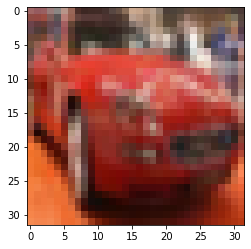

In [12]:
plt.imshow(X[5])

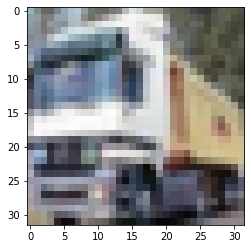

In [13]:
plt.imshow(X[1])

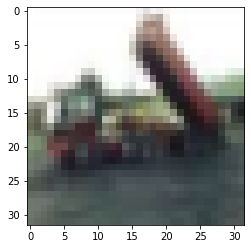

In [14]:
plt.imshow(X[2])

### Supporting Functions to Rearrange Data

### Encode Labels into One-Hot Format

In [15]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

## Set Up Image Data: Make it Ready to be Fed into 1st Conv Layer

In [16]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

### Set up image data: Calling Cifar Helper.set_up_images()

In [17]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


###  Supporting Functions to Build, Train, and Test CNN Model

In [18]:
# this function returns a tf. variable used to store weights in a filter 
# the variable is initialized with values that can be used to infiltrate weights
# the values are random numbers

def initialize_weights (filter_shape):
    init_random_dist = tf.truncated_normal(filter_shape, stddev=0.1)
    return (tf.Variable(init_random_dist))

In [19]:
# this function returns a tf. variable used to store bias
# the variable is initialized with values that can be used to intialize bias
# the values is intialized to 0.1

def initialize_bias(bias_shape):
    initial_bias_value = tf.constant(0.1, shape=bias_shape)
    return(tf.Variable(initial_bias_value))

###  convolution layer and perform convolution computation: dot product (x*W)

In [20]:
# define a function to set up a convolution layer (conv2d)
# parameters:
# --) inputs: {batch, H, W, channels}
# --) filter_shape:
# {filter H, filter W, in_channels (indepth= in_num_filters),out_channels(out_depth = out_num_filters)}
# for example: {5,5,1,32}

def create_convolution_layer_and_compute_dot_product (inputs, filter_shape):
    #intialize the weights in filter
    filter_intialized_with_weights = initialize_weights (filter_shape)
    #creating a convolution layer
    conv_layer_outputs = tf.nn.conv2d(inputs, filter_intialized_with_weights, strides=[1, 1, 1, 1], padding='SAME')
  #Return the convultion layer outputs
    return (conv_layer_outputs)

###  ReLU Layer and Perform Computation: Dot Product + Bias (x.W+b)

In [21]:
#setting up layer and then perform the computation
def create_relu_layer_and_compute_dotproduct_plus_b(inputs, filter_shape):
    b = initialize_bias([filter_shape[3]])
#creating relu layer 
    relu_layer_outputs = tf.nn.relu(inputs + b)
#relu layer outputs    
    return (relu_layer_outputs)

###   Pooling layer and reduce spatial size

In [22]:
def create_maxpool2by2_and_reduce_spatial_size(inputs):
#kernel size:2/2, stride= 2, max pooling method
    pooling_layer_outputs = tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
#returning the pooling layer   
    return(pooling_layer_outputs)

### Setting up fully connected layer and performing computation: (inputs*weights) + bias

In [23]:
#defining a dunction to create an Fc to perform computation and return the results, inputs oare the output of precedding layer
#the size of the outputs is the number of channels
def create_fully_conected_layer_and_compute_dotproduct_plus_bias(inputs, output_size):
    input_size = int(inputs.get_shape()[1])
    W = initialize_weights([input_size, output_size])  #intialize the weights
    b = initialize_bias([output_size])                  #intialize the bias where eaxh bias one output channel
    fc_xW_plus_bias_outputs = tf.matmul(inputs, W) + b   #perform the computation for the fc layer 
    return(fc_xW_plus_bias_outputs)

# PHASE I: Build CNN

In [24]:
import tensorflow as tf

### Create Placeholders for Inputs and Labels: x and y_true

In [25]:
# PLACEHOLDER

# Create a placeholder for the inputs data: x
# x: a 2D array
# x: a placeholder that can hold any number of rows/record

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [26]:
# PLACEHOLDER

# Create a placeholder for the labels of the inputs data: y_true
# y_true: a 2D array
# y_true: Can hold any number of rows/records

y_true = tf.placeholder(tf.float32, [None, 10])

### Reshape the Input Placeholder x: NOT NEED TO RESHAPE DATA HERE

In [27]:
# no need to reshapre

## Create 1st Convolution Layer

In [28]:
#creating 1st convoultional layer and input channel is 1 and output channel are 32 
#the shape of the filter is 5x5 and  after creating extract the features 
#get the results of output is dot product of inputs*weights
conv_layer_1_outputs \
=create_convolution_layer_and_compute_dot_product (x, filter_shape=[5, 5, 3, 32])

conv_layer_1_outputs \
= create_relu_layer_and_compute_dotproduct_plus_b (conv_layer_1_outputs, filter_shape=[5, 5, 3, 32])

In [29]:
#create pooling layer and reducing spatial size
pooling_layer_1_outputs = create_maxpool2by2_and_reduce_spatial_size (conv_layer_1_outputs)

## Create 2nd Convolutional Layer, ReLU Layer and Pooling Layer

In [30]:
#creating 2nd convolutionallayer and filter shape :5x5, inputs channels:32, output channel:64
#creating 2nd layer and extracting the features and get the results of the output that is dot product of inputs* weights
conv_layer_2_outputs \
= create_convolution_layer_and_compute_dot_product (pooling_layer_1_outputs, filter_shape=[5, 5, 32, 64])
#return the outputs of layers and creating relu for 1st convolution layer  and performing computation and returning the outputs of layer
conv_relu_layer_2_outputs \
= create_relu_layer_and_compute_dotproduct_plus_b (conv_layer_2_outputs, filter_shape=[5, 5, 32, 64])

In [31]:
pooling_layer_2_outputs = create_maxpool2by2_and_reduce_spatial_size (conv_relu_layer_2_outputs)

## Create 3rd convolutional layer, ReLU Layer and Pooling Layer

In [32]:
#creating 3nd convolutionallayer and filter shape :5x5, inputs channels:64, output channel:128
#creating 3nd layer and extracting the features and get the results of the output that is dot product of inputs* weights
conv_layer_3_outputs \
= create_convolution_layer_and_compute_dot_product (pooling_layer_2_outputs, filter_shape=[5, 5, 64, 128])
#return the outputs of layers and creating relu for 3rd convolution layer  and performing computation and returning the outputs of layer
conv_relu_layer_3_outputs \
= create_relu_layer_and_compute_dotproduct_plus_b (conv_layer_3_outputs, filter_shape=[5, 5, 64, 128])

In [33]:
pooling_layer_3_outputs = create_maxpool2by2_and_reduce_spatial_size (conv_relu_layer_3_outputs)

### Reshape and flatten data making it ready to be fed into 1st FC layer

In [34]:
#these are 3nd pooling layer outputs
pooling_layer_3_outputs_flat = tf.reshape(pooling_layer_3_outputs, [-1, 4 * 4 * 128])

## create 1st FC Layer, ReLU Layer, and output data to dropout layer

In [35]:
#creating outputlayer then feeding the output of the 2nd pooling as the inputs into this layer.
fc_layer_1_outputs \
    = create_fully_conected_layer_and_compute_dotproduct_plus_bias(pooling_layer_3_outputs_flat, output_size=3072)
fc_relu_layer_1_outputs = tf.nn.relu(fc_layer_1_outputs)

## create dropout layer  and dropout a fraction of outputs randomly

In [36]:
#creating dropoutlayer and decalring a placeholder
hold_prob = tf.placeholder(tf.float32)
#setting the output to zero so that it could be ignored in the next layer
fc_dropout_outputs = tf.nn.dropout(fc_relu_layer_1_outputs, keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Create final FC Layer (x * W + b) and produce final outputs

In [37]:
# creating a fully connected layer then we compute then return final classification outputs
y_pred = create_fully_conected_layer_and_compute_dotproduct_plus_bias(fc_dropout_outputs, output_size=10)

## Define loss function and calculate softmax cross entropy loss 

In [38]:
# we calculate the soft cross entrophy loss
softmax_cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
#to compute the mean of losses
cross_entropy_mean = tf.reduce_mean (softmax_cross_entropy_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Create an optimizer to optimize CNN model and set learning rate

In [39]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

## create a trainer to train CNN model

In [40]:
cnn_trainer = optimizer.minimize(cross_entropy_mean)

# PHASE II: Train and Test CNN Model on CIFAR-10 Dataset

## ...

In [41]:
vars_initializer = tf.global_variables_initializer()   #get a variable initializer

### setting up  the steps and collecting datapoints

In [42]:
steps = 4000  #setting the steps to 4000 

In [43]:
with tf.Session() as sess:

    sess.run(vars_initializer) #rthis command is to initialize all the variables
    for i in range(steps):
        batch_x, batch_y = ch.next_batch(100)  #each batch 100 images
#train the model and dropout prob---50% will be dropped
        sess.run(cnn_trainer, feed_dict={x: batch_x, y_true: batch_y, hold_prob: 0.5})
#test the model at each 100th step and run the block of code for each 100 times of accuracy
        if i % 100 == 0:
            print('ON STEP: {}'.format(i) )
            print('ACCURACY: ')
#compare to find matches of y_pred and y_true
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1) )
#cast the matches from integers to tf.float32 and calculate the acciracy using the mean of the matches
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
#testing the model at each 100th step,using test dataset and dropout:none (because of not training)
            test_accuracy = sess.run(acc,feed_dict={x:ch.test_images,\
                                                y_true:ch.test_labels,\
                                                hold_prob:1.0})
            print(test_accuracy)
            print('\n')


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=8

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_MWAIT_HINTS=0
   KMP_NUM_LOCKS_IN_BLOCK=1

ON STEP: 0
ACCURACY: 
0.1


ON STEP: 100
ACCURACY: 
0.3732


ON STEP: 200
ACCURACY: 
0.4486


ON STEP: 300
ACCURACY: 
0.4487


ON STEP: 400
ACCURACY: 
0.4767


ON STEP: 500
ACCURACY: 
0.5065


ON STEP: 600
ACCURACY: 
0.523


ON STEP: 700
ACCURACY: 
0.5151


ON STEP: 800
ACCURACY: 
0.5353


ON STEP: 900
ACCURACY: 
0.549


ON STEP: 1000
ACCURACY: 
0.5691


ON STEP: 1100
ACCURACY: 
0.5852


ON STEP: 1200
ACCURACY: 
0.5997


ON STEP: 1300
ACCURACY: 
0.5791


ON STEP: 1400
ACCURACY: 
0.5979


ON STEP: 1500
ACCURACY: 
0.6069


ON STEP: 1600
ACCURACY: 
0.6285


ON STEP: 1700
ACCURACY: 
0.6232


ON STEP: 1800
ACCURACY: 
0.6121


ON STEP: 1900
ACCURACY: 
0.632


ON STEP: 2000
ACCURACY: 
0.6128


ON STEP: 2100
ACCURACY: 
0.6396


ON STEP: 2200
ACCURACY: 
0.6437


ON STEP: 2300
ACCURACY: 
0.6059


ON STEP: 2400
ACCURACY: 
0.6295


ON STEP: 2500
ACCURACY: 
0.6021


ON STEP: 2600
ACCURACY: 
0.6439


ON STEP: 2700
ACCURACY: 
0.6602


ON STEP: 2800
ACCURACY: 
0.6344


ON STEP: 2900
ACCURACY: 
0.6383
